<a href="https://colab.research.google.com/github/rawatpremsingh999/tensorflow-coursera/blob/master/coursera_4213.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [2]:
def plot_series(time, series, format = '-', start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

def trend(time, slope = 0):
  return slope * time


def seasonal_pattern(season_time):
  """Just an arbitrary pattern, you can change it if you wish"""
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi),
                  1/np.exp(3 * season_time))
  

def seasonality(time, period, amplitude = 1, phase=0):
  """Repeats the same pattern at each period"""
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed = 42)


# split the dataset into training and validation
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]


window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

l0 = tf.keras.layers.Dense(10, input_shape = [window_size], activation='relu')

l1 = tf.keras.layers.Dense(10, activation='relu')

l2 = tf.keras.layers.Dense(1)


model = tf.keras.models.Sequential([l0, l1, l2])

model.compile(optimizer= tf.keras.optimizers.SGD(lr= 1e-6, momentum=0.9),
              loss= 'mse')

model.fit(dataset, epochs=100, verbose=1)


Epoch 1/100
31/31 [==============================] - 1s 2ms/step - loss: 355.2886
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 73.7745
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 60.4779
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 77.2330
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 65.8063
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 63.1980
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 67.1448
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 61.5851
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 55.5454
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 58.5353
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 55.3228
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 60.1327
Epoch 13/100
31/31 [====

In [6]:
l2.get_weights()

[array([[-0.45015863],
        [ 0.31364197],
        [-0.07417824],
        [-0.5026135 ],
        [ 0.07070544],
        [-0.14544599],
        [ 0.5776212 ],
        [ 0.07231808],
        [ 0.17143472],
        [ 0.4671834 ]], dtype=float32), array([-0.00523933], dtype=float32)]

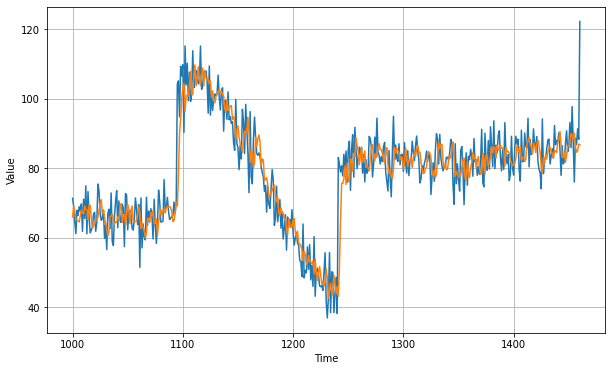

In [7]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
print("MSE: ",tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print("MAE: ",tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

MSE:  46.271893
MAE:  4.983188


In [127]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

l0 = tf.keras.layers.Dense(10, input_shape = [window_size], activation='relu')

l1 = tf.keras.layers.Dense(10, activation='relu')

l2 = tf.keras.layers.Dense(1)


model = tf.keras.models.Sequential([l0, l1, l2])


# learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))

# optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)

model.compile(optimizer=optimizer, loss='mse')

history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.0001, 0.0, 300.0)

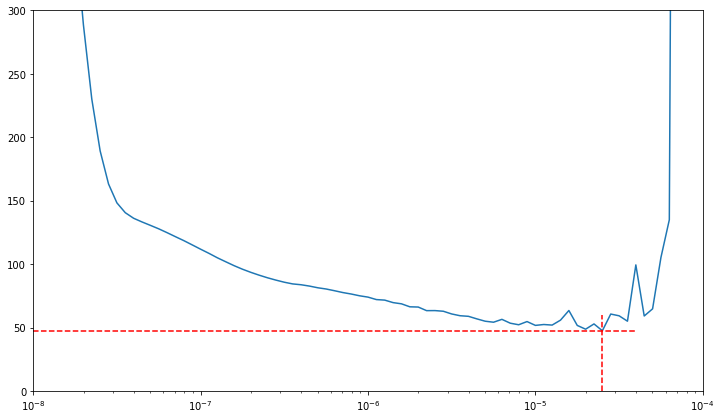

In [128]:
lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(12,7))
plt.semilogx(lrs, history.history["loss"])
plt.axhline(y = history.history['loss'][np.argmin(history.history['loss'])], xmax = 0.9, color='r', linestyle='--')
plt.axvline(x= lrs[np.argmin(history.history['loss'])], ymax=0.2, color='r', linestyle='--')
plt.axis([1e-8, 1e-4, 0, 300])

In [129]:
print("Learning rate {} where loss is minimum i.e. {}: ".format(lrs[np.argmin(history.history['loss'])],min(history.history['loss'])))

Learning rate 2.5118864315095798e-05 where loss is minimum i.e. 47.49384307861328: 


In [137]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([tf.keras.layers.Dense(10, input_shape = [window_size], activation='relu'),
                                    tf.keras.layers.Dense(10, activation='relu'), 
                                    tf.keras.layers.Dense(1)])

model.compile(optimizer= tf.keras.optimizers.SGD(lr=7e-06, momentum=0.9),
              loss= 'mse')

history = model.fit(dataset, epochs=500, verbose=0)


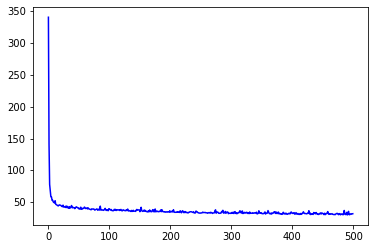

In [138]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[48.7427978515625, 52.341270446777344, 46.77191925048828, 46.19932174682617, 45.808807373046875, 44.9186897277832, 44.12624740600586, 45.17409896850586, 45.85251998901367, 45.437686920166016, 45.22063446044922, 44.34975814819336, 43.453285217285156, 43.00410842895508, 45.37864303588867, 42.40262985229492, 42.89040756225586, 42.281890869140625, 43.69316101074219, 41.51268005371094, 43.9945068359375, 43.00966262817383, 41.1312255859375, 40.53108596801758, 43.06795883178711, 40.42238235473633, 41.57478713989258, 43.338829040527344, 44.817596435546875, 41.1528434753418, 42.02798080444336, 41.63984680175781, 41.4630012512207, 40.01286697387695, 40.381011962890625, 42.300926208496094, 42.7398567199707, 41.9512825012207, 41.154441833496094, 41.233089447021484, 39.50823211669922, 40.157310485839844, 39.289222717285156, 42.19767379760742, 39.01826095581055, 38.94880294799805, 40.391849517822266, 40.18310546875, 40.42424011230469, 42.39752197265625, 41.540584564208984, 40.0637321472168, 40.47013

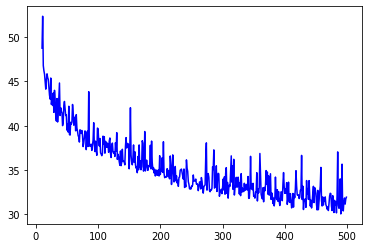

In [139]:
# Plot loss after the 10th epochs
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

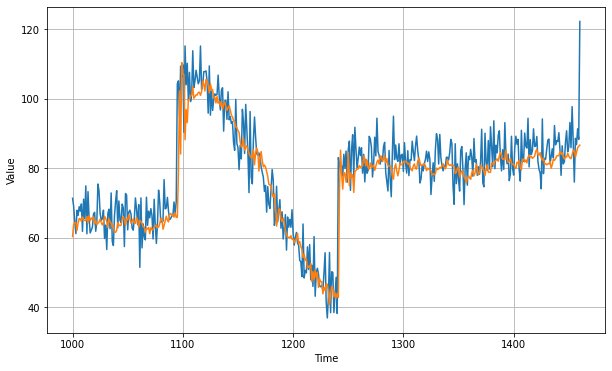

In [140]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [141]:
print("MSE: ",tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print("MAE: ",tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

MSE:  46.57302
MAE:  4.9483013
